# GloVe vectors (Tilo)

I used [this](https://jsomers.net/glove-codenames/) blogpost as a guide. It's a fun and easy read about using GloVe vectors to play the popular boadgame Codenames so if that sounds intresting check it out. I use some code snippets from this blogpost.
 
I downloaded my GloVe vectors from http://nlp.stanford.edu/data/glove.42B.300d.zip. This file has vectors for more than a million words, so I just used the vectors from the top 100,000 words. To follow allong you'll need this top 100,000 words file. You might be able to get it from me or the GitHub. If it's not on the GitHub you can follow [these instructions](#Go-test-it-out-youself!) to obtain the right data.

If you want to skip to see the recommender in action [click this link](#Testing-out-the-recommender). It seems to work well.

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from scipy import spatial
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt


df_origin = pd.read_json("data_5scheduler.json")

#create "department" collumn based on "identifier" column
df_origin["department"] = [s.split("-")[0].upper() for s in df_origin["identifier"]]

print("Our dataset originally contained", len(df_origin), "observations.")
print("There are", len(set(df_origin["department"])), "distinct departments.")

Our dataset originally contained 4443 observations.
There are 107 distinct departments.


In [2]:
# embeddings associates each word with a GloVe embedding
# will contain embeddings for the 100,000 most common words
embeddings = {}
with open("./top_100000.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings[word] = vector
        
words_with_embeddings = set([w for w in embeddings])

### Calculating description embedings in 3 steps


1. Transfrom a class description into a list of words. Make sure this list is free from punctuation and all lower case.

2. Filter out [stop words](https://en.wikipedia.org/wiki/Stop_word) and words we don't have emeddings for.

3. Find the average of embedding of all the words in our list of words.

In [3]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def calculate_description_embeding(description):
    
    # clean description
    description = remove_punctuation(description).lower().strip()
    words = description.split(" ")
    stops = set(stopwords.words('english'))
    
    # filter out stop words and words we don't have embeddings for
    words = [w for w in words if not w in stops]
    words = [w for w in words if (w in words_with_embeddings)]
    
    
    valid_words_count = len(words)
    if valid_words_count == 0:
        return (None, 0)
    
    
    
    # calculate embedding 
    average = sum([embeddings[w] for w in words])/len(words)
    
    return (average, valid_words_count)

In [4]:
# calculate embeddings for all courses
tupples = [calculate_description_embeding(desc) for desc in df_origin["description"]]
df_origin["description embeddings"] = list(zip(*tupples))[0]
df_origin["used words"] = list(zip(*tupples))[1]

# check how many class descriptions don't have embeddings
nacount = df_origin["description embeddings"].isna().sum()
total_embeddings = len(df_origin["description embeddings"])
print(nacount, " out of ", total_embeddings, " do not have embeddings")

# drop classes without embeddings 
df = df_origin.dropna(subset=["description embeddings"])
print("classes without embeddings removed")
nacount = df["description embeddings"].isna().sum()
total_embeddings = len(df["description embeddings"])
print(nacount, " out of ", total_embeddings, " do not have embeddings")

98  out of  4443  do not have embeddings
classes without embeddings removed
0  out of  4345  do not have embeddings


/Users/reneau-cardoso/enter/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


At this point I have some questions about our model that could lead to improvements:
- What kinds of descriptions could we not compute embeddings for? Are we losing any classes we might not want to lose?
- How many words is each embedding based on? We might expect embeddings based on few words to perform poorly.

First let's take a look at the classes we dropped:

In [5]:
df_dropped = df_origin.loc[df_origin["description embeddings"].isna()]
df_dropped

,title,identifier,description,source,credits,instructors,offered,prerequisites,corequisites,currently_offered,fee,department,description embeddings,used words
1262,Carving and Shaping Realities,ART-025R-PO,,Pomona,0,[],,,,False,0,ART,None,0
1300,Mediterranean Cities,ARHI-176-JT,,Pomona,0,[],,,,False,0,ARHI,None,0
1389,Computational Chemistry,CHEM-164-PO,,Pomona,0,[],,,,False,0,CHEM,None,0
1547,Health Economics: Applications to Health Polic...,ECON-119-PO,,Pomona,0,[],,,,False,0,ECON,None,0
1565,Urban Economics,ECON-153-PO,,Pomona,0,[],,,,False,0,ECON,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4356,Religion and Politics in Medieval and Early Mo...,RLST-165-CM,,Pitzer,0,[],,,,False,0,RLST,None,0
4370,Sociology of Popular Music,SOC-071-PZ,,Pitzer,0,[],,,,False,0,SOC,None,0
4440,IGLAS Seminar,GLAS-185-PZ,,Pitzer,0,[],,,,False,0,GLAS,None,0
4441,Global Local Research Workshop,GLAS-19-4A,,Pitzer,0,[],,,,False,0,GLAS,None,0


In [6]:
df_dropped.loc[df_origin["description"] != ""]

,title,identifier,description,source,credits,instructors,offered,prerequisites,corequisites,currently_offered,fee,department,description embeddings,used words
2120,"Lab, Theory I",MUS-080L-PO,.,Pomona,0,[Rosa Li],Each semester.,MUS 080 PO,,True,0,MUS,None,0
2122,"Lab, Theory II",MUS-081L-PO,.,Pomona,0,"[G. Blankenburg, Staff]",Each fall.,MUS 081 PO,,False,0,MUS,None,0
2124,"Lab, Theory III",MUS-082L-PO,.,Pomona,0,[Gayle R. Blankenburg],Each spring.,MUS 082 PO,,True,0,MUS,None,0


It appears all of the classes we could not calculate descriptions for just didn't have descriptions at all except for three which had "." as their description. Some of the classes misisng descriptions actually do have descriptions. I found the description for Computational Chemistry on the Pomona website: https://catalog.pomona.edu/preview_entity.php?catoid=43&ent_oid=2262.

Now let's take a look at how many words are used to calculate each embedding. This would be the number of words in each description that's included in our list of the 100,000 most common words but not a stop word.

In [7]:
df["used words"].describe()

count    4345.000000
mean       37.280552
std        27.003099
min         1.000000
25%        23.000000
50%        33.000000
75%        48.000000
max       484.000000
Name: used words, dtype: float64

In [8]:
print(sum(df["used words"] < 10), "out of", len(df), "of our description embeddings are based on less than 10 words")

228 out of 4345 of our description embeddings are based on less than 10 words


<AxesSubplot:>

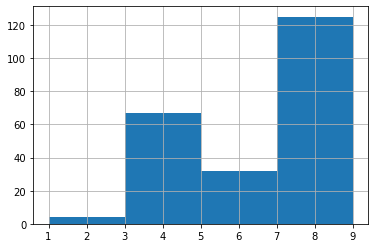

In [9]:
# let's take a look at how these embeddings with low words are distributed
df.loc[df["used words"] < 10]["used words"].hist(bins=4)

In [10]:
# uncomment out print statements to see some of the descriptions with low used words
df_low_words = df.loc[df["used words"] < 3][["title","description", "used words"]].head(20).to_numpy()
for row in df_low_words:
    print(row[0] + " (" +str(row[2]) + " used words)")
    print(row[1])
    print()
    

Senior Thesis (2 used words)
Senior Thesis

Senior Thesis in German (1 used words)
. Course or half-course.

Senior Thesis (1 used words)
Course or half-course.

Foundations of Neuroscience (2 used words)
For description, see NEUR 95L 



In [11]:
# Here we create two dictionaries which we will need for the recommend function.
# The first, description_embeddings, associates each course title with its corresponding vector.
# The second, department, associates each course title with the department it's from.

dic = df[["title","description embeddings", "department"]].set_index("title").dropna().to_dict()
description_embeddings = dic['description embeddings']
department = dic['department']

In [12]:
len(description_embeddings)

3687

### Recommending courses in 3 steps (for one input)

1. Find the distance (using cosine similarity) between a given course and all other courses.

2. calculate cost for each course with the following equation where same_department is a boolean variable:

$$\text{cost} = \text{distance} + \text{same_department} \cdot \text{penalty}$$

3. Sort by cost and return the 10 courses with the lowest cost.

### Recommending courses in 3 steps (for multiple inputs)

1. Perform the above steps for each imput but keep the 5 lowest intead of the 10 lowest.

2. Combine the lists of 5 top courses into one big list.

3. Sort that list by cost, keep the top 10 best results, and return it.

In [13]:
def recommend_ugly(user_input, same_dep_penalty = .05):
    '''Finds 10 closest courses for a given course by taking the cosine similarity of their description embeddings.'''
    
    def distance(user_input, reference):
        if user_input in description_embeddings:
            same_department = department[user_input] == department[reference]
            cost = spatial.distance.cosine(description_embeddings[user_input], description_embeddings[reference])
            cost += same_department*same_dep_penalty
            return cost      
        else:
            input_embdeding = calculate_description_embeding(user_input)[0]
            return spatial.distance.cosine(input_embdeding, description_embeddings[reference])
        

    def closest_courses(user_input):
        unsorted = [ (course, distance(user_input, course))
                    for course in description_embeddings.keys()]
        
        return sorted(unsorted, key = lambda w: w[1])
    
    
    if type(user_input) == str:
        return closest_courses(user_input)[:10]
    elif type(user_input) == list:
        unsorted = []
        for ui in user_input:
            unsorted += closest_courses(ui)[:5]
        return sorted(unsorted, key = lambda w: w[1])[:10]
    else:
        return None

# like recommend_ugly but doesn't drops costs for each input so the output is less cluttered
def recommend(user_input):
    return [t[0] for t in recommend_ugly(user_input)]

In [14]:
recommend_ugly(['Linear Algebra', 'Language and Gender','Econometrics'])

[('Statistical Inference', 0.03128349781036377),
 ('Language and Globalization', 0.040086567401885986),
 ('Applied Statistics', 0.04116100072860718),
 ('Bayesian Statistics', 0.04230308532714844),
 ('Calculus and Discrete Models for Applications', 0.0443570613861084),
 ('Methods in Modern Modeling', 0.04454725980758667),
 ('The Socialization of Gender: A Developmental Perspective',
  0.04617804288864136),
 ('Chinese Language in Society', 0.04904049634933472),
 ('Language, Identity and Violence', 0.049272358417510986),
 ('Linear Algebra', 0.05)]

# Testing out the recommender
Here I test the recommender on some classes I've taken or am taking. 

In [15]:
recommend('Linear Algebra')

['Linear Algebra',
 'Mathematical Methods of Physics',
 'Linear Algebra with Computing',
 'Engineering Mathematics',
 'Numerical Linear Algebra',
 'Precalculus',
 'Calculus with Precalculus',
 'Advanced Structural Dynamics',
 'Quantum Mechanics with Computational Applications',
 'Dynamics of Rigid Bodies']

In [16]:
recommend('Language and Gender')

['Language and Globalization',
 'The Socialization of Gender: A Developmental Perspective',
 'Chinese Language in Society',
 'Language, Identity and Violence',
 'Language and Gender',
 'Language and Power',
 'Writing Stories about the Bodies in East Asia',
 'Sociology through Literature',
 'Place, Power, and Difference',
 'Introduction to French Linguistics']

Even though Econometrics is in the econ deparment it's really a stats class and it seems like the recommender is aware of this.

In [17]:
recommend('Econometrics')

['Statistical Inference',
 'Applied Statistics',
 'Bayesian Statistics',
 'Calculus and Discrete Models for Applications',
 'Methods in Modern Modeling',
 'Representations of High-Dimensional Data',
 'Time Series',
 'Computational Statistics',
 'Differential Equations and Modeling',
 'Differential Equations/Modeling']

In [18]:
recommend('Statistical Inference')

['Econometrics',
 'Introduction to Statistics for Psychologists',
 'Applied Microeconometrics',
 'Advanced Statistics I: Analysis of Variance and Regression',
 'Data Analysis and Programming for the Life Sciences.',
 'Applied Econometrics',
 'Advanced Data Analysis',
 'Advanced Data Analysis (Biology)',
 'Statistical Inference',
 'Statistics for Politics and International Relations']

In [19]:
desc = 'This course is an introduction to ordinary differential equations. Topics include first order equations, linear equations, reduction of order, a variation of parameters, spring motion and other applications, Cauchy-Euler equations, power series solutions, Laplace transforms, and systems of linear differential equations.'
recommend_ugly(desc)

[('Fourier Series and Boundary Value Problems', 0.05224210023880005),
 ('Differential Equations', 0.05364745855331421),
 ('Introduction to Partial Differential Equations', 0.05573534965515137),
 ('Dynamics of Rigid Bodies', 0.0625578761100769),
 ('Mathematical Methods of Physics', 0.06309062242507935),
 ('Calculus with Precalculus', 0.0642896294593811),
 ('Scientific Computing', 0.06583541631698608),
 ('Graduate Partial Differential Equations', 0.0668376088142395),
 ('Numerical Analysis', 0.06706458330154419),
 ('Topics in Applied Mathematics', 0.07019644975662231)]

In [20]:
recommend_ugly(['Linear Algebra', 'Language and Gender','Econometrics', desc])

[('Statistical Inference', 0.03128349781036377),
 ('Language and Globalization', 0.040086567401885986),
 ('Applied Statistics', 0.04116100072860718),
 ('Bayesian Statistics', 0.04230308532714844),
 ('Calculus and Discrete Models for Applications', 0.0443570613861084),
 ('Methods in Modern Modeling', 0.04454725980758667),
 ('The Socialization of Gender: A Developmental Perspective',
  0.04617804288864136),
 ('Chinese Language in Society', 0.04904049634933472),
 ('Language, Identity and Violence', 0.049272358417510986),
 ('Linear Algebra', 0.05)]

In [55]:
recommend_ugly("fun")

[('Doodling in Math Class', 0.23751461505889893),
 ('Playground Games', 0.2578643560409546),
 ('Beach Games/Lawn Sports', 0.25794774293899536),
 ('Psychology of Humor', 0.281485915184021),
 ('Pickleball', 0.28362613916397095),
 ('Introduction to Comedy Improvisation', 0.2867879867553711),
 ('Speed Lacrosse', 0.29597198963165283),
 ('Cardio Kickboxing', 0.29834550619125366),
 ("Shakespeareand's Comedies", 0.3050910234451294),
 ('Soccer', 0.3083198666572571)]

In [53]:
recommend_ugly("goofy")

[('Psychology of Humor', 0.5985851883888245),
 ('Monsters in Literature', 0.6271322071552277),
 ("Shakespeareand's Comedies", 0.6336044371128082),
 ('Playground Games', 0.6381522119045258),
 ('Shakespeare: Comedies and Histories', 0.6390984058380127),
 ('Doodling in Math Class', 0.6414847671985626),
 ('Beach Games/Lawn Sports', 0.6429370939731598),
 ('Contemporary Animation Practice', 0.6452821791172028),
 ('The Last Laugh', 0.6506808698177338),
 ('Animated Russia: Cartoons and the Language of Culture', 0.6595902442932129)]

In [54]:
recommend_ugly("humerus")

[('Functional Human Anatomy and Biomechanics: Limbs and Movement',
  0.8164952248334885),
 ('Differential Geometry', 0.866811141371727),
 ('Biomechanics', 0.8686682730913162),
 ('Neuromuscular Physiology in Health and Disease', 0.8757568374276161),
 ('Functional Human Anatomy and Biomechanics: Back and Core Stabilization',
  0.8822715431451797),
 ('Algebraic Topology', 0.8946893811225891),
 ('Molecular Genetics', 0.9037071466445923),
 ('Mechanics and Wave Motion', 0.9043416753411293),
 ('Clinical Neuropsychology', 0.9065663814544678),
 ('Hyperbolic Geometry', 0.9091087505221367)]

In [51]:
recommend_ugly("Integral")

[('Complex Variables and Integral Transforms', 0.319080114364624),
 ('Calculus with Precalculus', 0.3238018751144409),
 ('Introduction to Partial Differential Equations', 0.32523345947265625),
 ('Complex Analysis', 0.33479905128479004),
 ('Functions of a Complex Variable', 0.33814871311187744),
 ('Electromagnetic Theory and Optics', 0.3411712646484375),
 ('Precalculus', 0.34748923778533936),
 ('Single and Multivariable Calculus', 0.3487210273742676),
 ('Fourier Series and Boundary Value Problems', 0.3555677533149719),
 ('Mathematical Analysis II', 0.3563992381095886)]

In [50]:
recommend_ugly("Apple")

[('Machine Learning for Artists', 0.42368388175964355),
 ('Media Archives', 0.4695510268211365),
 ('Advanced Web Projects', 0.47021007537841797),
 ('Introduction to Computer Music', 0.4783790111541748),
 ('Learning from YouTube', 0.47972261905670166),
 ('Intermediate Video Art', 0.4814078211784363),
 ('Crossing Media: Moving Between Analog and Digital in Printmaking',
  0.48795682191848755),
 ('The Social Life of Digital Media', 0.48997795581817627),
 ('Asian American Studies: Independent Research', 0.49265652894973755),
 ('Asian Studies: Independent Research', 0.49265652894973755)]

In [56]:
recommend_ugly("Appple")

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [58]:
recommend_ugly("Intagram Reddit Facebook")

[('Media Archives', 0.4646304249763489),
 ('Online Feminist Spaces', 0.4963669180870056),
 ('Machine Learning for Artists', 0.5093809068202972),
 ('Social Epistemology', 0.5197667479515076),
 ('Teaching and Tutoring of Writing', 0.5258621573448181),
 ('Learning from YouTube', 0.5289127230644226),
 ('The Social Life of Digital Media', 0.5331858694553375),
 ('Psychology of Humor', 0.5347039699554443),
 ('Politics of Journalism', 0.5400834083557129),
 ('Political Reading and Writing I', 0.5453697144985199)]

In [49]:
recommend_ugly("Pomona College")

[('Introduction to the History of Judaism and Jewish Thought',
  0.2768803834915161),
 ('Old Testament Theology', 0.2768803834915161),
 ("The Qur'an and Its Interpreters", 0.2768803834915161),
 ('Environmental Ethics and Mystical Traditions in Islam', 0.2768803834915161),
 ('Archaeology of the Bible', 0.2768803834915161),
 ('Introduction to Islamic Studies', 0.2768803834915161),
 ('Women in Genesis', 0.2768803834915161),
 ("Feminism and Qur'anic Studies", 0.2768803834915161),
 ("Classical Arabic Literature and the Quar'an", 0.2768803834915161),
 ('Applied Feminist Applications', 0.28877121210098267)]

In [48]:
recommend_ugly("Friedrich Nietzsche")

[('Continental Thought', 0.25913822650909424),
 ('Political Philosophy and History', 0.4797922968864441),
 ('Nietzsche', 0.4806082248687744),
 ('Les Philosophes: Paradoxes of Nature', 0.48364830017089844),
 ('Great German Fiction', 0.504810631275177),
 ('History of Modern Philosophy', 0.51120725274086),
 ('History of Philosophy: Ancient', 0.5226336121559143),
 ('The Romantic Revolution', 0.5236397683620453),
 ('History of Aesthetics', 0.5262622535228729),
 ('The Natural Law', 0.5325171053409576)]

# Some stuff I'd like to fix about the recommender
I think it seems to be working pretty well. However, here's a list of stuff I'd like to fix about the recommender:
- Handle classes that have the same name but are different; currently if two classes have the same name only one of their descriptions is being used. (Or at least I think that's what's going on with duplicate course names).
- Handle hyphonated words better; when I calculate description embeddings I get rid of all punctuation (e.g. "single-gender" becomes "singlegender"). 
- Investigate why some words don't have embeddings. For example, "single-gender" doesn't have an embedding but that's something that could potentially be fixed if it was treated as two words or the hyphen was not removed. 

# Go test it out youself!


To get the code running you'll need a file called "top_100000.txt" with the top 100,000 GloVe vectors. You can get the GloVe vectors from http://nlp.stanford.edu/data/glove.42B.300d.zip. Be warned though; the unzipped file is 5 GB. After you've got the unzipped file, run this in your terminal to get the "top_100000.txt" file.
```
head -n 100000 glove.42B.300d.txt > top_100000.txt
```
Feel free to play around with with the recomender. If you run the cell bellow it will give you a list of all the courses that have embeddings. 

In [21]:
[desc for desc in description_embeddings]

['Introduction to American Cultures',
 'Print and American Culture',
 'Hyphenated Americans',
 'Life: Knowledge, Belief, and Cultural Practices',
 'Introduction to the Anthropology of Science and Technology',
 'War and Conflict',
 'Rationalities',
 'A History of Landscape Photography',
 'Modern and Contemporary Art Practices',
 'Photography',
 'Workshop in Hand Press Printing',
 'Undisciplined Art',
 'Social Documentation/Asian American',
 'Pacific Islanders and Education',
 'Introduction to Asian American History: 1850-Present',
 'Introduction to Pacific Islander History',
 'South Asian American Experience',
 'Contemporary Asian American Issues',
 'Stars, Planets, and Life: Introduction to Astrobiology',
 'Introduction to Astrophysics',
 'Observational Astronomy',
 'Star Formation and the Interstellar Medium',
 'Cosmology and Extragalactic Astrophysics',
 'High Energy Astrophysics',
 'Stellar Structure and Evolution',
 'Planetary Astrophysics',
 'Galactic Astronomy',
 'Biology Laborat

In [22]:
# This code creates description_GloVe_embeddings.txt which you will need for Part 2
text = ""
for desc in description_embeddings:
    hyphonated_desc = "-".join(desc.split())
    vec = [str(val) for val in description_embeddings[desc]]
    text += hyphonated_desc + " " + " ".join(vec) + "\n"
    
with open("description_GloVe_embeddings.txt", "w") as f:
    f.write(text)